In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from information_estimation import *
from image_utils import *

from led_array.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

Opening BSCCM
Opened BSCCM


In [2]:
edge_crop = 32
patch_size = 15

num_images = 5000
num_patches = 5000

channel = 'DPC_Right'
confidence_interval = 90
num_bootstrap_samples = 50

images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)


## Trying to fix low photon counts

# TODO: try adding a small amount of noise to pixels in low light conditions to see if it rescues entropy estiamte?

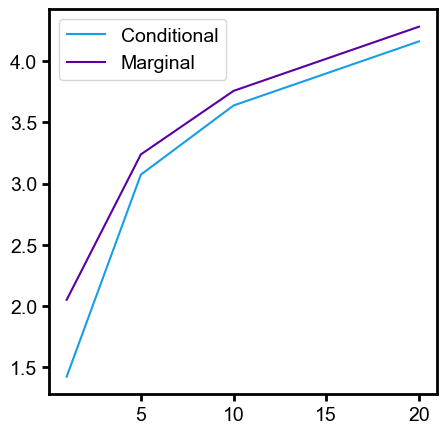

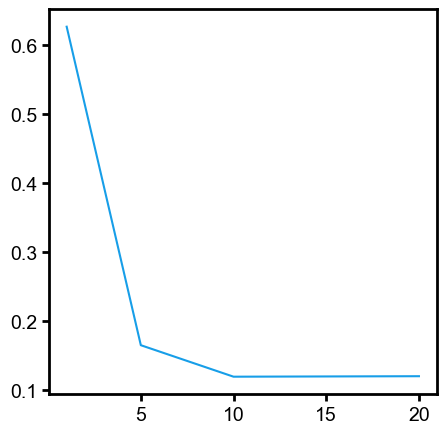

In [16]:
from information_estimation import *

# photons_per_pixel_values = [0.01, 0.1, 0.5, 1, 2, 4, 10, 50]
photons_per_pixel_values = [1, 5, 10, 20,]
# photons_per_pixel_values = [10, 20, 50 , 100, 300]

conditionals = []
marginals = []
mi = []
for photons_per_pixel in photons_per_pixel_values:
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images), seed=123)
    # mi.append(estimate_mutual_information(noisy_images=noisy_patches, verbose=True))
    h_y_given_x = compute_conditional_entropy(noisy_patches) / np.log(2)
    h_y_gaussian = gaussian_entropy_estimate(noisy_patches, stationary=True, eigenvalue_floor=1e-4, show_plot=False) / np.log(2)
    conditionals.append(h_y_given_x)
    marginals.append(h_y_gaussian)
    mi.append(h_y_gaussian - h_y_given_x)

# plot both
plt.figure(figsize=(5, 5))
plt.plot(photons_per_pixel_values, conditionals, label='Conditional')
plt.plot(photons_per_pixel_values, marginals, label='Marginal')
plt.legend()

plt.figure(figsize=(5, 5))
plt.plot(photons_per_pixel_values, mi, label='MI')


## error bars

In [19]:
photons_per_pixel_values = [20, 50 , 100, 200, 300, 600]


mi_means = []
mi_confidences = []

noisy_patches_for_display = []
for photons_per_pixel in tqdm(photons_per_pixel_values):
    # TODO: this doesnt work?
    # noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=photons_per_pixel / np.mean(images))
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images))

    mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False))
    mi_means.append(mi_mean)
    mi_confidences.append(mi_confidence)
    noisy_patches_for_display.append(noisy_patches[:10])

mi_means = np.array(mi_means)
mi_confidences = np.array(mi_confidences)

  0%|          | 0/6 [00:00<?, ?it/s]

Running bootstraps:   0%|          | 0/50 [00:00<?, ?it/s]/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWarning: Mean pixel value is 19.66. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWarning: Mean pixel value is 19.57. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_available):.2f}. Mutual information estimates may be inaccurate at low photon counts.")
/home/hpinkard_waller/GitRepos/EncodingInformation/information_estimation.py:227: UserWarning: Mean pixel value is 19.59. Mutual information estimates may be inaccurate at low photon counts.
  warnings.warn(f"Mean pixel value is {np.mean(clean_images_if_avai

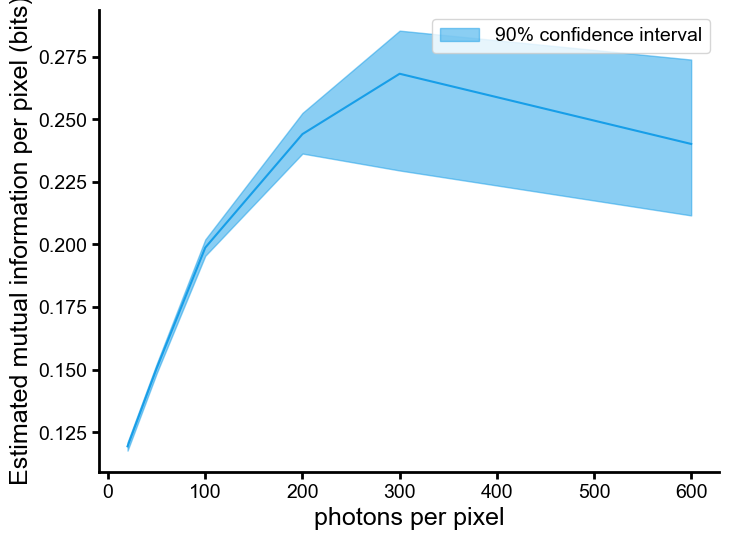

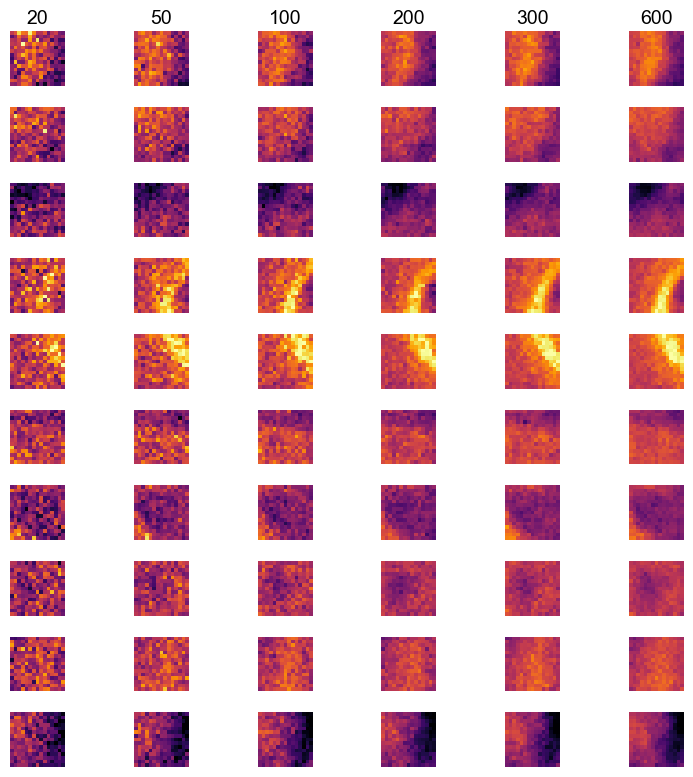

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
colors = get_color_cycle()
ax.plot(photons_per_pixel_values, mi_means, color=colors[0])
ax.fill_between(photons_per_pixel_values, onp.array(mi_confidences)[:, 0], onp.array(mi_confidences)[:, 1], color=colors[0], alpha=0.5, label='90% confidence interval')
clear_spines(ax)
ax.set(xlabel='photons per pixel', ylabel='Estimated mutual information per pixel (bits)')
# show legend fo confidence interval
ax.legend()

fig, axs = plt.subplots(len(noisy_patches_for_display[0]), len(noisy_patches_for_display), figsize=(8, 8))
for i, noisy_patches in enumerate(noisy_patches_for_display):
    vmin, vmax = np.percentile(noisy_patches, 0.3), np.percentile(noisy_patches, 99.7)
    for j, patch in enumerate(noisy_patches):
        axs[j, i].imshow(patch, cmap='inferno', vmin=vmin, vmax=vmax)
        axs[j, i].axis('off')
        if i == 0:
            axs[j, i].set_ylabel(f'Patch {j+1}')
        if j == 0:
            axs[j, i].set_title(f'{photons_per_pixel_values[i]}')
plt.tight_layout()

In [23]:
# create sample data
channel_names = ['DPC_Right', 'LED119', 'Brightfield']
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = 300
num_bootstrap_samples = 8
confidence_interval = 90

mi_means = []
mi_confidences = []
for channel_name in tqdm(channel_names):
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=True)
    patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)
    noisy_patches = add_noise(patches * photons_per_pixel / np.mean(images))

    mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
                estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False))
    mi_means.append(mi_mean)
    mi_confidences.append(mi_confidence)
    
mi_means = np.array(mi_means)
mi_confidences = np.array(mi_confidences)

100%|██████████| 3/3 [01:46<00:00, 35.54s/it]


# TODO: something inconsistent between above and below plots

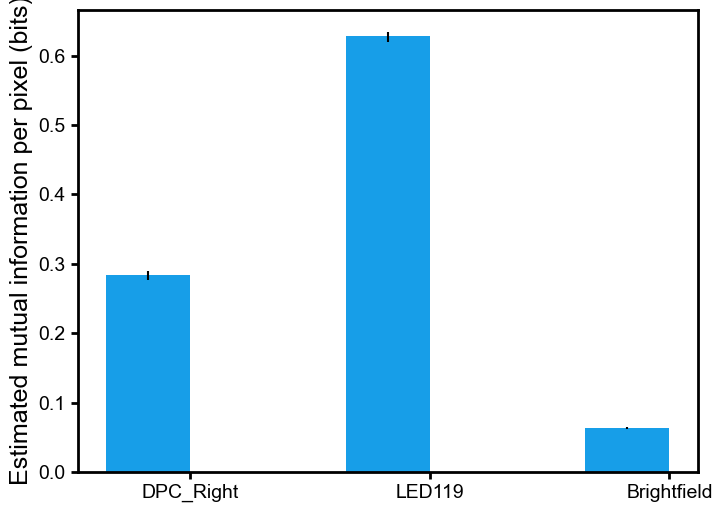

In [38]:
# set the width of the bars
bar_width = 0.35


# create a paired bar plot of results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))


# create the bar plots
bar_width = 0.35
lower_errors = mi_means - mi_confidences[:, 0]
upper_errors = mi_confidences[:, 1] - mi_means
plt.bar(np.arange(len(channel_names)), mi_means, yerr=np.array([lower_errors, upper_errors]), width=bar_width)

# add labels, title, and legend
plt.xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
plt.ylabel('Estimated mutual information per pixel (bits)')
plt.show()


## Why does adding to experimental data create problems

In [ ]:
# why does adding to experimental data make it worse?
# edge_crop = 24
# patch_size = 50
# channel = 'LED119'

# num_images = 10000
# num_patches = 10000

# photons_per_pixel = 150

# images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False)
# patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches)

# noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=photons_per_pixel / np.mean(images))
# # noisy_patches = add_shot_noise(patches * photons_per_pixel / np.mean(images))
# estimate_mutual_information(noisy_patches, show_eigenvalue_plot=False, eigenvalue_floor=1, verbose=True)

# # cov_mat = compute_stationary_cov_mat(noisy_patches, verbose=True)
# # evs = np.linalg.eigvalsh(cov_mat)

# # # plot them
# # fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# # ax.semilogy(evs)

## TODO: How do samples from GP approx look like with different patch sizes:
- starting from 1 pixel
- maybe this belongs in the other notebook